In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.animation as animation
from scipy.sparse import dok_matrix
import multiprocessing as mp
import scipy as sp
import matplotlib.ticker as ticker
import project

In [2]:
#General plot parameters and size definition
plt.style.use('science')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams.update({"axes.grid" : True})
plt.rcParams.update({"axes.titlesize": 18})
plt.rcParams.update({"axes.labelsize": 15})

In [3]:
def spikelet_fun(strength,num_neurons):
    return (strength*  -7.26668869e+01 - 1.32272004e-03) *((num_neurons)*-1.84361670e-01)

In [4]:
#loading up the parameters

params_HH = project.utils.load_HH()
params_LIF = project.utils.load_LIF()
params_IZH = project.utils.load_ISH()
params_ML = project.utils.load_ML()

#time parameters
t_final = 5000
dt = 0.01


#Other constant parameters
num_neurons = 2
#Variation for the initial conditions
volt_var = np.random.normal(0,5,num_neurons)
rec_var = np.random.normal(0,1,num_neurons)
Isyn = np.zeros((num_neurons,num_neurons))
tau = 0.65
V0 = -65 * np.ones(num_neurons) + volt_var
y0 = -65 * np.ones(num_neurons) + volt_var
w0 = 0 * np.ones(num_neurons) + rec_var
u0 = 0 * np.ones(num_neurons) + rec_var
n0 = 0 * np.ones(num_neurons) + rec_var
m0 = 0 * np.ones(num_neurons) + rec_var
h0 = 0 * np.ones(num_neurons) + rec_var
order = 2


#fixing random seed
np.random.seed(1234)

#generating the intensities
I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))

for i in range(0,num_neurons):
    x_normal = np.random.normal(0,5,int(t_final/dt))
    x_if = np.random.normal(0,1.5,int(t_final/dt))
    I_HH[:,i] = 2.5 * (1 + 2*x_normal)
    I_IF[:,i] = 2.5 * (1 + 2*x_if)
    I_IZH[:,i] = 2.5 * (1 + 2*x_normal)
    I_ML[:,i] = 2.5 * (1+ 2*x_normal)
  

HH_gap_junction = np.zeros((int(t_final/dt),num_neurons))
HH_synaptic_current = np.zeros((int(t_final/dt),num_neurons))

IF_gap_junction = np.zeros((int(t_final/dt),num_neurons))
IF_synaptic_current = np.zeros((int(t_final/dt),num_neurons))

IZH_gap_junction = np.zeros((int(t_final/dt),num_neurons))
IZH_synaptic_current = np.zeros((int(t_final/dt),num_neurons))

ML_gap_junction = np.zeros((int(t_final/dt),num_neurons))
ML_synaptic_current = np.zeros((int(t_final/dt),num_neurons))

In [5]:
k = np.linspace(0.001,0.9,20)
gap_current_HH = np.zeros_like(k)
gap_current_mean_HH = np.zeros_like(k)
gap_current_variance_HH = np.zeros_like(k)
noise_variance_HH = np.zeros_like(k)
chi_HH = np.zeros_like(k)
rel_HH = np.zeros_like(k)
gap_current_IF = np.zeros_like(k)
gap_current_mean_IF = np.zeros_like(k)
gap_current_variance_IF = np.zeros_like(k)
noise_variance_IF = np.zeros_like(k)
chi_IF = np.zeros_like(k)
rel_IF = np.zeros_like(k)
gap_current_IZH = np.zeros_like(k)
gap_current_mean_IZH = np.zeros_like(k)
gap_current_variance_IZH = np.zeros_like(k)
noise_variance_IZH = np.zeros_like(k)
chi_IZH = np.zeros_like(k)
rel_IZH = np.zeros_like(k)
gap_current_ML = np.zeros_like(k)
gap_current_mean_ML = np.zeros_like(k)
gap_current_variance_ML = np.zeros_like(k)
noise_variance_ML = np.zeros_like(k)
chi_ML = np.zeros_like((k,int(t_final/dt),num_neurons))
rel_ML = np.zeros_like((k,int(t_final/dt),num_neurons))
data_HH = np.zeros_like((k,int(t_final/dt),num_neurons))
data_IF = np.zeros_like((k,int(t_final/dt),num_neurons))
data_IZH = np.zeros_like((k,int(t_final/dt),num_neurons))
data_ML = np.zeros_like((k,int(t_final/dt),num_neurons))
t_R = 0.5
t = np.linspace(0,t_final,int(t_final/dt))

for i in range(len(k)):
    dataHH_adjust, completeHH_adjust, matrixHH_adjust = project.models.HH_Neuron_Pairs_test(dt,t_final,order,V0,n0,m0,h0,*params_HH,I_HH,Isyn,k[i],tau,HH_gap_junction,HH_synaptic_current)
    dataIF_adjust, completeIF_adjust, matrixIF_adjust = project.models.LIF_Neuron_Pairs_tests(dt, t_final,order,y0,*params_LIF,I_IF,Isyn,k[i],tau,spikelet_fun(k[i],2), IF_gap_junction, IF_synaptic_current)
    dataIZH_adjust, completeIZH_adjust, matrixIZH_adjust = project.models.IZH_Neuron_Pairs_tests(dt,t_final,order,y0,u0,I_IZH,Isyn,*params_IZH,k[i],tau,IZH_gap_junction,IZH_synaptic_current)
    dataML_adjust, completeML_adjust, matrixML_adjust = project.models.ML_Neuron_Pairs_tests(dt,t_final,2,y0,w0,*params_ML,I_ML,Isyn,k[i],tau,ML_gap_junction, ML_synaptic_current)

    data_HH[i] = dataHH_adjust[:,0]
    gap_current_HH[i] = np.mean(HH_gap_junction[:,0])
    gap_current_mean_HH[i] = np.mean(np.mean(HH_gap_junction,axis=1))
    gap_current_variance_HH[i] = np.mean(np.var(HH_gap_junction,axis=1))
    noise_variance_HH[i] = np.mean(np.var(I_HH,axis=1))
    chi_HH[i] = project.utils.compute_chi(dataHH_adjust.T)
    rel_HH[i], a = project.utils.compute_Reliability(matrixHH_adjust,t,t_R,num_neurons)

    data_IF[i] = dataIF_adjust[:,0]
    gap_current_IF[i] = np.mean(IF_gap_junction[:,0])
    gap_current_mean_IF[i] = np.mean(np.mean(np.abs(IF_gap_junction),axis=1))
    gap_current_variance_IF[i] = np.mean(np.var(IF_gap_junction,axis=1))
    noise_variance_IF[i] = np.mean(np.var(I_IF,axis=1))
    chi_IF[i] = project.utils.compute_chi(dataIF_adjust.T)
    rel_IF[i], a = project.utils.compute_Reliability(matrixIF_adjust,t,t_R,num_neurons)

    data_IZH[i] = dataIZH_adjust[:,0]
    gap_current_IZH[i] = np.mean(IZH_gap_junction[:,0])
    gap_current_mean_IZH[i] = np.mean(np.mean(np.abs(IZH_gap_junction),axis=1))
    gap_current_variance_IZH[i] = np.mean(np.var(IZH_gap_junction,axis=1))
    noise_variance_IZH[i] = np.mean(np.var(I_IZH,axis=1))
    chi_IZH[i] = project.utils.compute_chi(dataIZH_adjust.T)
    rel_IZH[i], a = project.utils.compute_Reliability(matrixIZH_adjust,t,t_R,num_neurons)

    data_ML[i] = dataML_adjust[:,0]
    gap_current_ML[i] = np.mean(ML_gap_junction[:,0])
    gap_current_mean_ML[i] = np.mean(np.mean(np.abs(ML_gap_junction),axis=1))
    gap_current_variance_ML[i] = np.mean(np.var(ML_gap_junction,axis=1))
    noise_variance_ML[i] = np.mean(np.var(I_ML,axis=1))
    chi_ML[i] = project.utils.compute_chi(dataML_adjust.T)
    rel_ML[i], a = project.utils.compute_Reliability(matrixML_adjust,t,t_R,num_neurons)

In [6]:
np.savetxt('gap_current/gap_current_HH.txt',gap_current_HH)
np.savetxt('gap_current/gap_current_mean_HH.txt',gap_current_mean_HH)
np.savetxt('gap_current/gap_current_variance_HH.txt',gap_current_variance_HH)
np.savetxt('gap_current/noise_variance_HH.txt',noise_variance_HH)
np.savetxt('gap_current/chi_HH.txt',chi_HH)
np.savetxt('gap_current/rel_HH.txt',rel_HH)
np.savetxt('gap_current/data_HH.txt',data_HH)
np.savetxt('gap_current/gap_current_IF_spikelet_off.txt',gap_current_IF)
np.savetxt('gap_current/gap_current_mean_IF_spikelet_off.txt',gap_current_mean_IF)
np.savetxt('gap_current/gap_current_variance_IF.txt',gap_current_variance_IF)
np.savetxt('gap_current/noise_variance_IF.txt',noise_variance_IF)
np.savetxt('gap_current/chi_IF.txt',chi_IF)
np.savetxt('gap_current/rel_IF.txt',rel_IF)
np.savetxt('gap_current/data_IF.txt',data_IF)
np.savetxt('gap_current/gap_current_IZH.txt',gap_current_IZH)
np.savetxt('gap_current/gap_current_mean_IZH.txt',gap_current_mean_IZH)
np.savetxt('gap_current/gap_current_variance_IZH.txt',gap_current_variance_IZH)
np.savetxt('gap_current/noise_variance_IZH.txt',noise_variance_IZH)
np.savetxt('gap_current/chi_IZH.txt',chi_IZH)
np.savetxt('gap_current/rel_IZH.txt',rel_IZH)
np.savetxt('gap_current/data_IZH.txt',data_IZH)
np.savetxt('gap_current/gap_current_ML.txt',gap_current_ML)
np.savetxt('gap_current/gap_current_mean_ML.txt',gap_current_mean_ML)
np.savetxt('gap_current/gap_current_variance_ML.txt',gap_current_variance_ML)
np.savetxt('gap_current/noise_variance_ML.txt',noise_variance_ML)
np.savetxt('gap_current/chi_ML.txt',chi_ML)
np.savetxt('gap_current/rel_ML.txt',rel_ML)
np.savetxt('gap_current/data_ML.txt',data_ML)

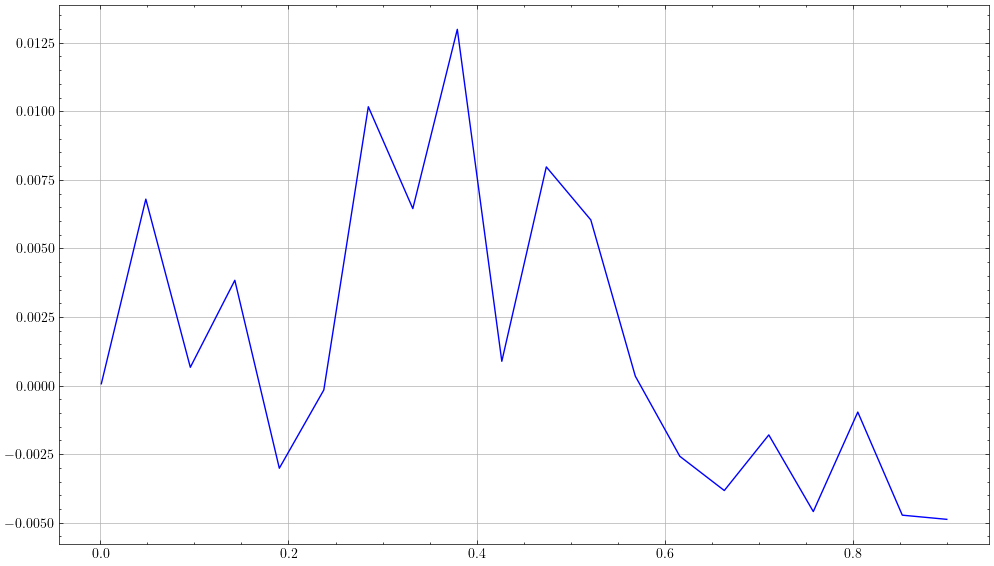

In [7]:
plt.plot(k,gap_current_HH,label='HH',color='b')

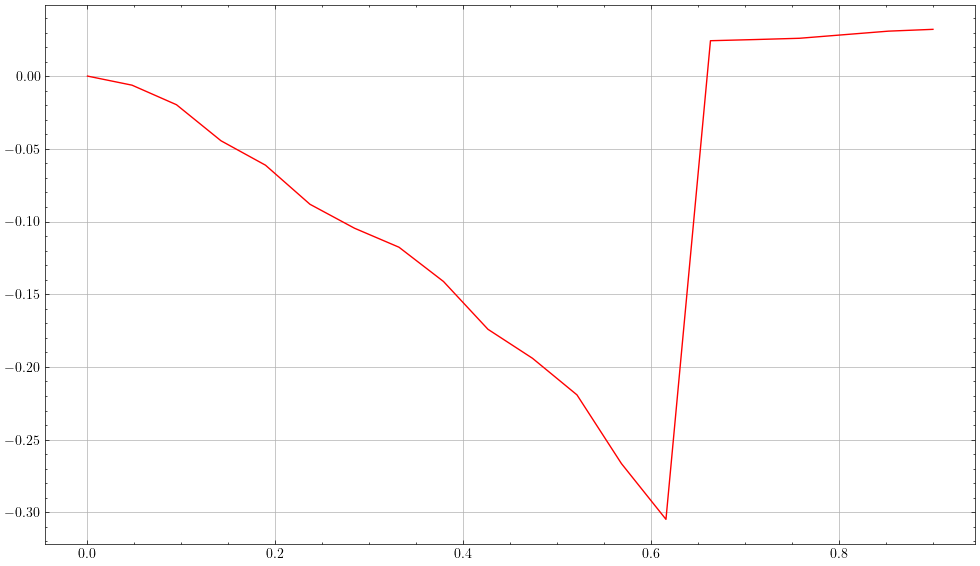

In [8]:
plt.plot(k,gap_current_IF,label='IF', color='r')

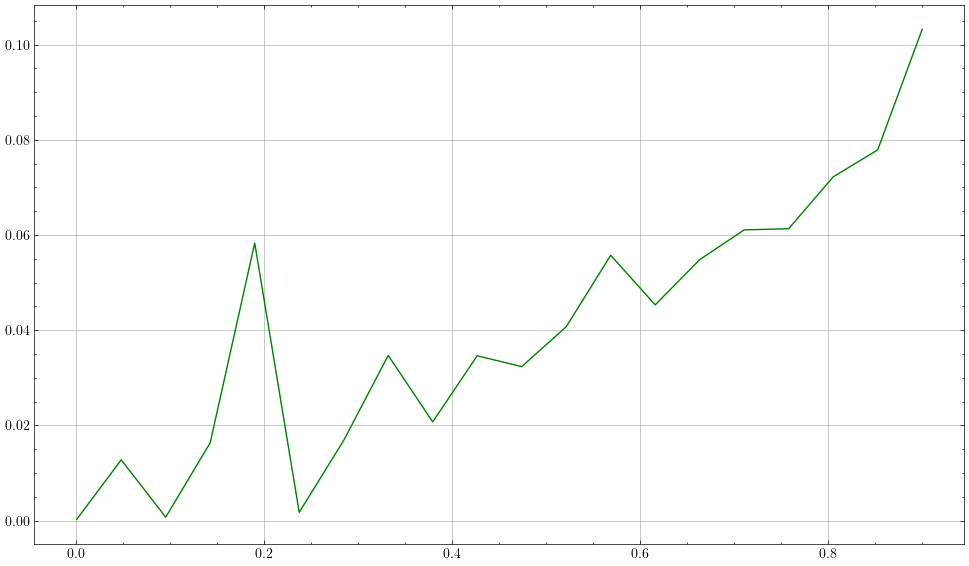

In [9]:
plt.plot(k,gap_current_IZH,label='IZH',color='g')


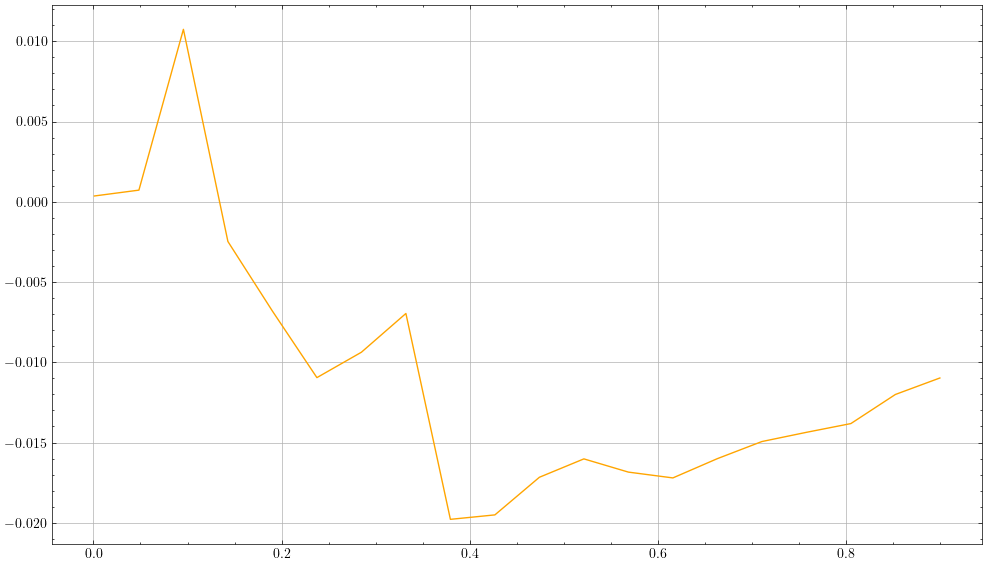

In [10]:
plt.plot(k,gap_current_ML,label='ML',color='orange')


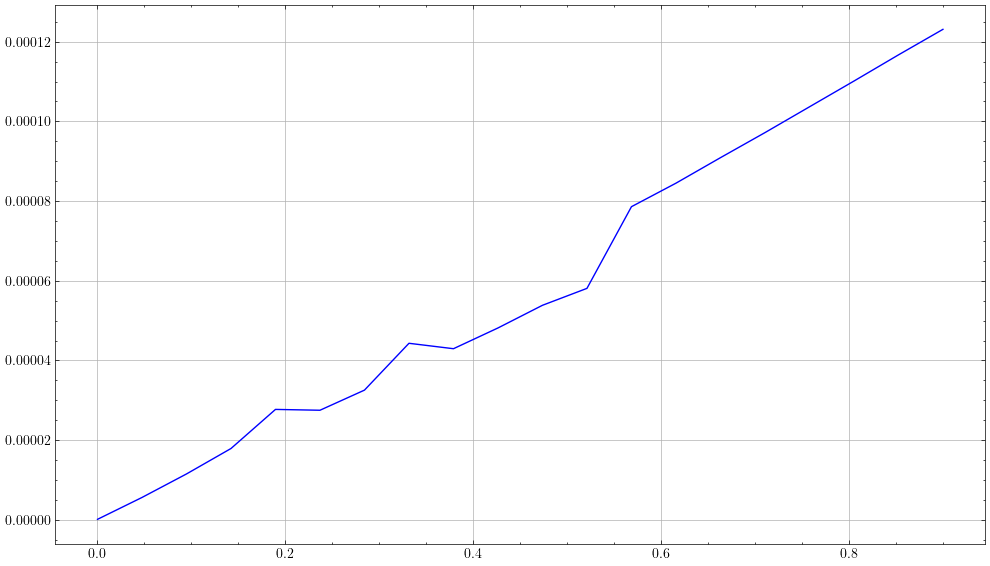

In [11]:
plt.plot(k,gap_current_mean_HH,label='HH',color='b')


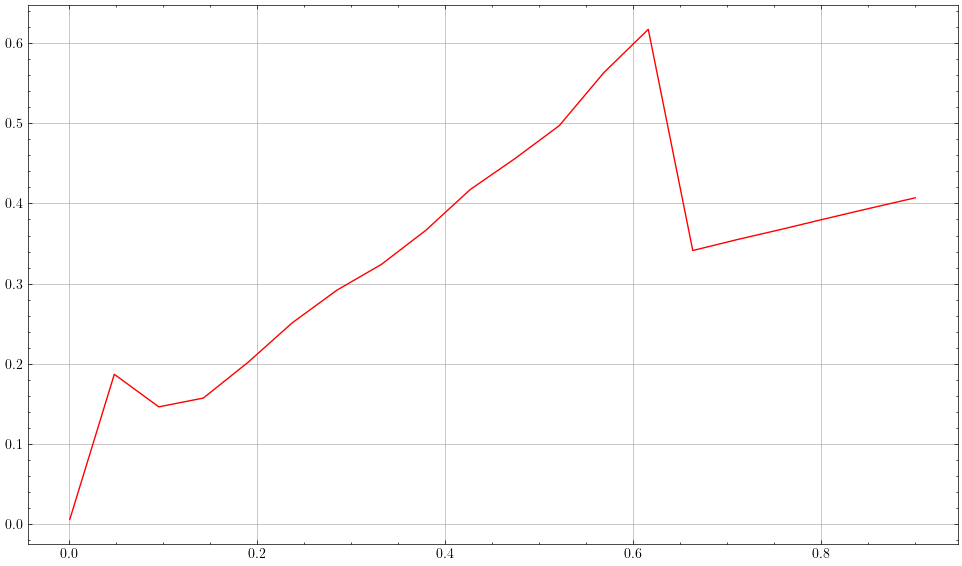

In [12]:
plt.plot(k,gap_current_mean_IF,label='IF', color='r')


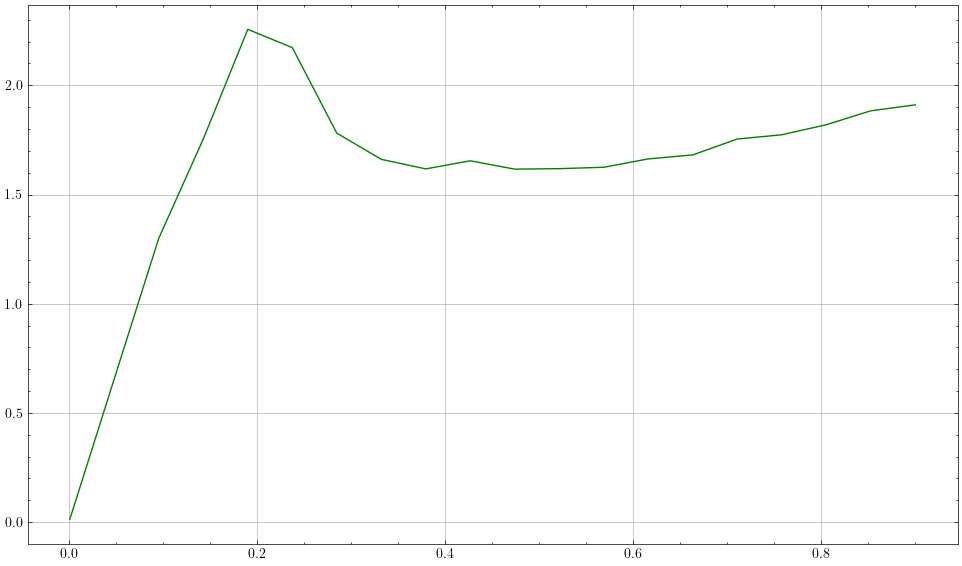

In [13]:
plt.plot(k,gap_current_mean_IZH,label='IZH',color='g')


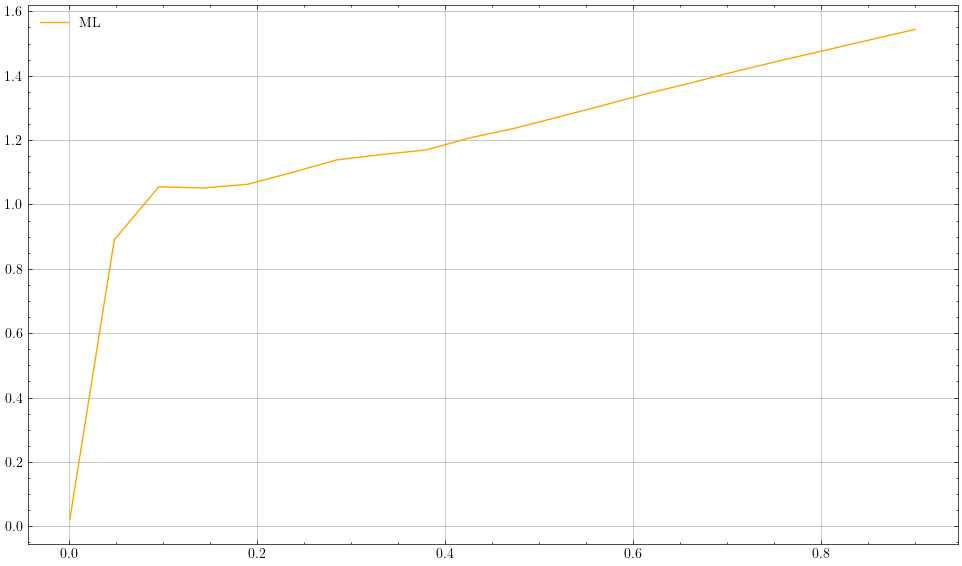

In [14]:
plt.plot(k,gap_current_mean_ML,label='ML',color='orange')
plt.legend()